# Import and Export Data for Santa Catarina

We want to answer the folowing questions:

* What are the top 3 most exported products by State for the years 2017, 2018 and 2019?
* What are the top 3 most imported products by State for the years 2017, 2018 and 2019?
* What are the top 3 most exported products in each month of 2019 by State?
* What is the percentage of total national exports by State in 2019?
* What is the percentage of total national imports by State in 2019?
* Prediction of value of top 3 exported products by month from Santa Catarina to each target Country.
* Prediction of value of top 3 imported products by month from Santa Catarina from each source Country.

## Contents





## Part 1: Data Wrangling for Exports

First step to address our analysis will be to download the files, unzip them, clean them and finally organize the best way possible. I have decided to store the link to the government website and download it as we execute the notebook instead of uploading the file as Git LFS because those file locations **should not** change at all. Considering we are betting on the Brazilian government efficiency, we will store the MD5 of the used files "just in case" they ever change for any reason. One faster way to do this is simply download the zip files yourself and put them in the data folder.

In [28]:
#imports
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import os
import asyncio
import hashlib
import base64
import zipfile
import matplotlib.pyplot as plt

EXP_MD5 = b'qQlAf4t9CVrpQ9h+fMMqfw=='
IMP_MD5 = b'X5m1GyzT+AlRGNciPVHrOA=='

In [2]:
#download files (have patience young padawan...)
async def download_to_data_folder(file_url:str)->str:
    local_filename = 'data/'+file_url.split('/')[-1]
    with requests.get(file_url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            downloaded = 0
            for chunk in r.iter_content(chunk_size=32768): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    downloaded += 32768
                    print(file_url.split('/')[-1]+'  '+str(downloaded),end='\r')
    return local_filename

async def download_all_files()->list:
    request_list = []
    request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/comexstat-bd/ncm/EXP_COMPLETA.zip'))
    request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip'))
    return asyncio.gather(*request_list)

if not os.path.exists('data/EXP_COMPLETA.zip'):
    file_list = await download_all_files()

In [3]:
#check MD5
for file in os.listdir('data/'):
    if file == 'EXP_COMPLETA.zip' or file == 'IMP_COMPLETA.zip':
        file_hash = hashlib.md5()
        with open('data/'+file,'rb') as f:
            for chunk in iter(lambda: f.read(2**20*file_hash.block_size), b''):
                file_hash.update(chunk)
        if base64.b64encode(file_hash.digest()) != EXP_MD5 and base64.b64encode(file_hash.digest()) != IMP_MD5:
            print(EXP_MD5)
            print(IMP_MD5)
            print(base64.b64encode(file_hash.digest()))
            raise Exception('Wrong file downloaded!')

In [4]:
#unzip files
for file in os.listdir('data/'):
    print(file)
    if file[-3:] == 'zip':
        with zipfile.ZipFile('data/'+file,"r") as zip_ref:
            zip_ref.extractall("data/")
            print('Extracted '+file)

EXP_COMPLETA.csv
EXP_COMPLETA.zip
Extracted EXP_COMPLETA.zip
IMP_COMPLETA.csv
IMP_COMPLETA.zip
Extracted IMP_COMPLETA.zip
README.txt


We start with exports. One important point we notice are the file sizes. One has around 1.5G unzipped, the other has 2.15G. Those may be a problem for python if you are using a computer with less than 8G RAM Memory.

Let´s import the first one.

In [5]:
exp_df = pd.read_csv('data/EXP_COMPLETA.csv', delimiter=';')

We will replace the names with more human friendly ones, and we notice that some of the data is using codes like integers, not in a human friendly naming system. Those will have to be addressed as well. Reading the documentation in http://www.mdic.gov.br/index.php/comercio-exterior/estatisticas-de-comercio-exterior/base-de-dados-do-comercio-exterior-brasileiro-arquivos-para-download , we can download the missing tables and change our data to a more friendly one.

First thing I learned was what FOB means! https://www.ipea.gov.br/desafios/index.php?option=com_content&view=article&id=2115:catid=28&Itemid=23

So, the column VL_FOB should be renamed to Amount(USD). We also need to download the remaining tables with more human friendly definitions so we get our final Dataframe. Another impotant aspect to notice is that we will only need data from 2017 - 2019, so we will filter those in order to spare some memory space.




In [6]:
#Filtering years
exp_df.query('CO_ANO in [2017,2018,2019]', inplace=True)





In [7]:
#Renaming
exp_df.rename(
    columns={
        "CO_ANO":"Ano",
        "VL_FOB":"Amount(USD)",
        "KG_LIQUIDO":"Kg",
        "SG_UF_NCM":"Estado",
        "CO_MES":"Mes"
    },inplace=True)


In [8]:
def download_missing_tables():
    request_list = []
    if not os.path.exists('data/PAIS.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/PAIS.csv'))
    if not os.path.exists('data/VIA.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/VIA.csv'))
    if not os.path.exists('data/NCM.csv'):
        request_list.append(download_to_data_folder('http://www.mdic.gov.br/balanca/bd/tabelas/NCM.csv'))
    if len(request_list)>0:
        return asyncio.gather(*request_list)
    else:
        return None

download_missing_tables()

<_GatheringFuture pending>

In [10]:
pais_df = pd.read_csv('data/PAIS.csv', delimiter=';', encoding="latin-1")


In [11]:
via_df = pd.read_csv('data/VIA.csv', delimiter=';', encoding="latin-1")


In [12]:
produto_df = pd.read_csv('data/NCM.csv', delimiter=';', encoding="latin-1")


In [13]:
exp_df = exp_df.merge(pais_df,how='inner',on='CO_PAIS')


In [14]:
exp_df.drop(['CO_PAIS','QT_ESTAT','CO_PAIS_ISON3','NO_PAIS_ING','CO_PAIS_ISOA3','NO_PAIS_ESP'],axis=1,inplace=True)


In [15]:
exp_df = exp_df.merge(via_df,how='inner',on='CO_VIA')
exp_df = exp_df.merge(produto_df,how='inner',on=['CO_NCM','CO_UNID'])


In [16]:
exp_df.drop([
    'CO_NCM',
    'CO_UNID',
    'CO_VIA',
    'CO_URF',
    'CO_PPI',
    'CO_FAT_AGREG',
    'CO_CUCI_ITEM',
    'CO_CGCE_N3',
    'CO_SIIT',
    'CO_ISIC4',
    'CO_EXP_SUBSET',
    'NO_NCM_ESP',
    'NO_NCM_ING',
    'CO_SH6',
    'CO_PPE'
],axis=1,inplace=True)


After some manipulations and merging of Dataframes, we finally have the ideal Dataframe with all information we need in a human friendly naming system.

In [17]:
exp_df.rename(
    columns={
        "NO_VIA":"Via",
        "NO_PAIS":"Pais",
        "NO_NCM_POR":"Produto"
    },inplace=True)
column_order = ['Ano','Mes','Estado','Pais','Via','Produto','Kg','Amount(USD)']
exp_df = exp_df[column_order]
exp_df.head(10)

,Ano,Mes,Estado,Pais,Via,Produto,Kg,Amount(USD)
0,2017,5,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,61327,312310
1,2017,5,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,1092,3570
2,2017,4,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,58772,281605
3,2017,8,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,95000,491717
4,2017,5,MG,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,2970,16919
5,2017,8,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,40324,228961
6,2017,3,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,20213,66990
7,2017,2,PR,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,21078,75652
8,2017,10,SC,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,144439,662794
9,2017,10,MG,Bolívia,RODOVIARIA,Combinações de refrigeradores e congeladores (...,7138,42485


Next thing is to check for NAs, but there should not be many because all our merging was done using inner joins (we discarded information that was missing in either tables).

In [18]:
exp_df.isna().sum()

Ano            0
Mes            0
Estado         0
Pais           0
Via            0
Produto        0
Kg             0
Amount(USD)    0
dtype: int64

## Part 2: Analysing Exports

Next step in our analysis is to answer the first question: list the top 3 exports by estate in 2017, 2018 and 2019.

In [49]:
exp_grouped = exp_df.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Ano'],ascending=False)
exp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
115117,2019,TO,"Soja, mesmo triturada, exceto para semeadura",772631871
115054,2019,TO,"Carnes desossadas de bovino, congeladas",155101002
115064,2019,TO,"Milho em grão, exceto para semeadura",78543244
74880,2018,TO,"Soja, mesmo triturada, exceto para semeadura",995302750
74837,2018,TO,"Carnes desossadas de bovino, congeladas",88538892
74838,2018,TO,"Carnes desossadas de bovino, frescas ou refrig...",25932145
35046,2017,TO,"Soja, mesmo triturada, exceto para semeadura",755967278
34997,2017,TO,"Carnes desossadas de bovino, congeladas",78877967
35008,2017,TO,"Milho em grão, exceto para semeadura",53312114
115021,2019,SP,Óleos brutos de petróleo,3830462450


We have 26 States in Brazil, now we just have to find out how many different products we have to think about the best representation.

In [50]:
exp_grouped['Produto'].drop_duplicates().count()

68

In [54]:
exp_grouped['Produto'].drop_duplicates()

115117         Soja, mesmo triturada, exceto para semeadura
115054              Carnes desossadas de bovino, congeladas
115064                 Milho em grão, exceto para semeadura
74838     Carnes desossadas de bovino, frescas ou refrig...
115021                             Óleos brutos de petróleo
                                ...                        
35365     Outros aparelhos para filtrar ou depurar líquidos
74974     Outras madeiras compensadas, constituídas excl...
74911           Castanha-do-pará, fresca ou seca, com casca
74977     Outras miudezas comestíveis de bovino, congeladas
39        Outras madeiras de não coníferas perfilada (co...
Name: Produto, Length: 68, dtype: object

The names are hard to understand and there are many similar products in different categories. For this reason, we will rename them and merge when necessary.

In [ ]:
name_dict = {}
name_dict['madeiras'] = "Madeira"
name_dict['petróleo'] = "Petróleo"
name_dict['Milho'] = "Milho"
name_dict['Soja'] = "Soja"
name_dict['bovino'] = "Carne Bovina"
name_dict['açúcares'] = "Açúcar"
name_dict['aviões'] = "Aviões"
name_dict['Suco (sumo) de laranja'] = "Suco de Laranja"
name_dict['calçados'] = "Calçados"
name_dict['galos/galinhas'] = "Frango"
name_dict['Tabaco'] = "Tabaco"
name_dict['Plataforma de perfuração'] = "Maquinário"
name_dict['Barcos'] = "Barcos"


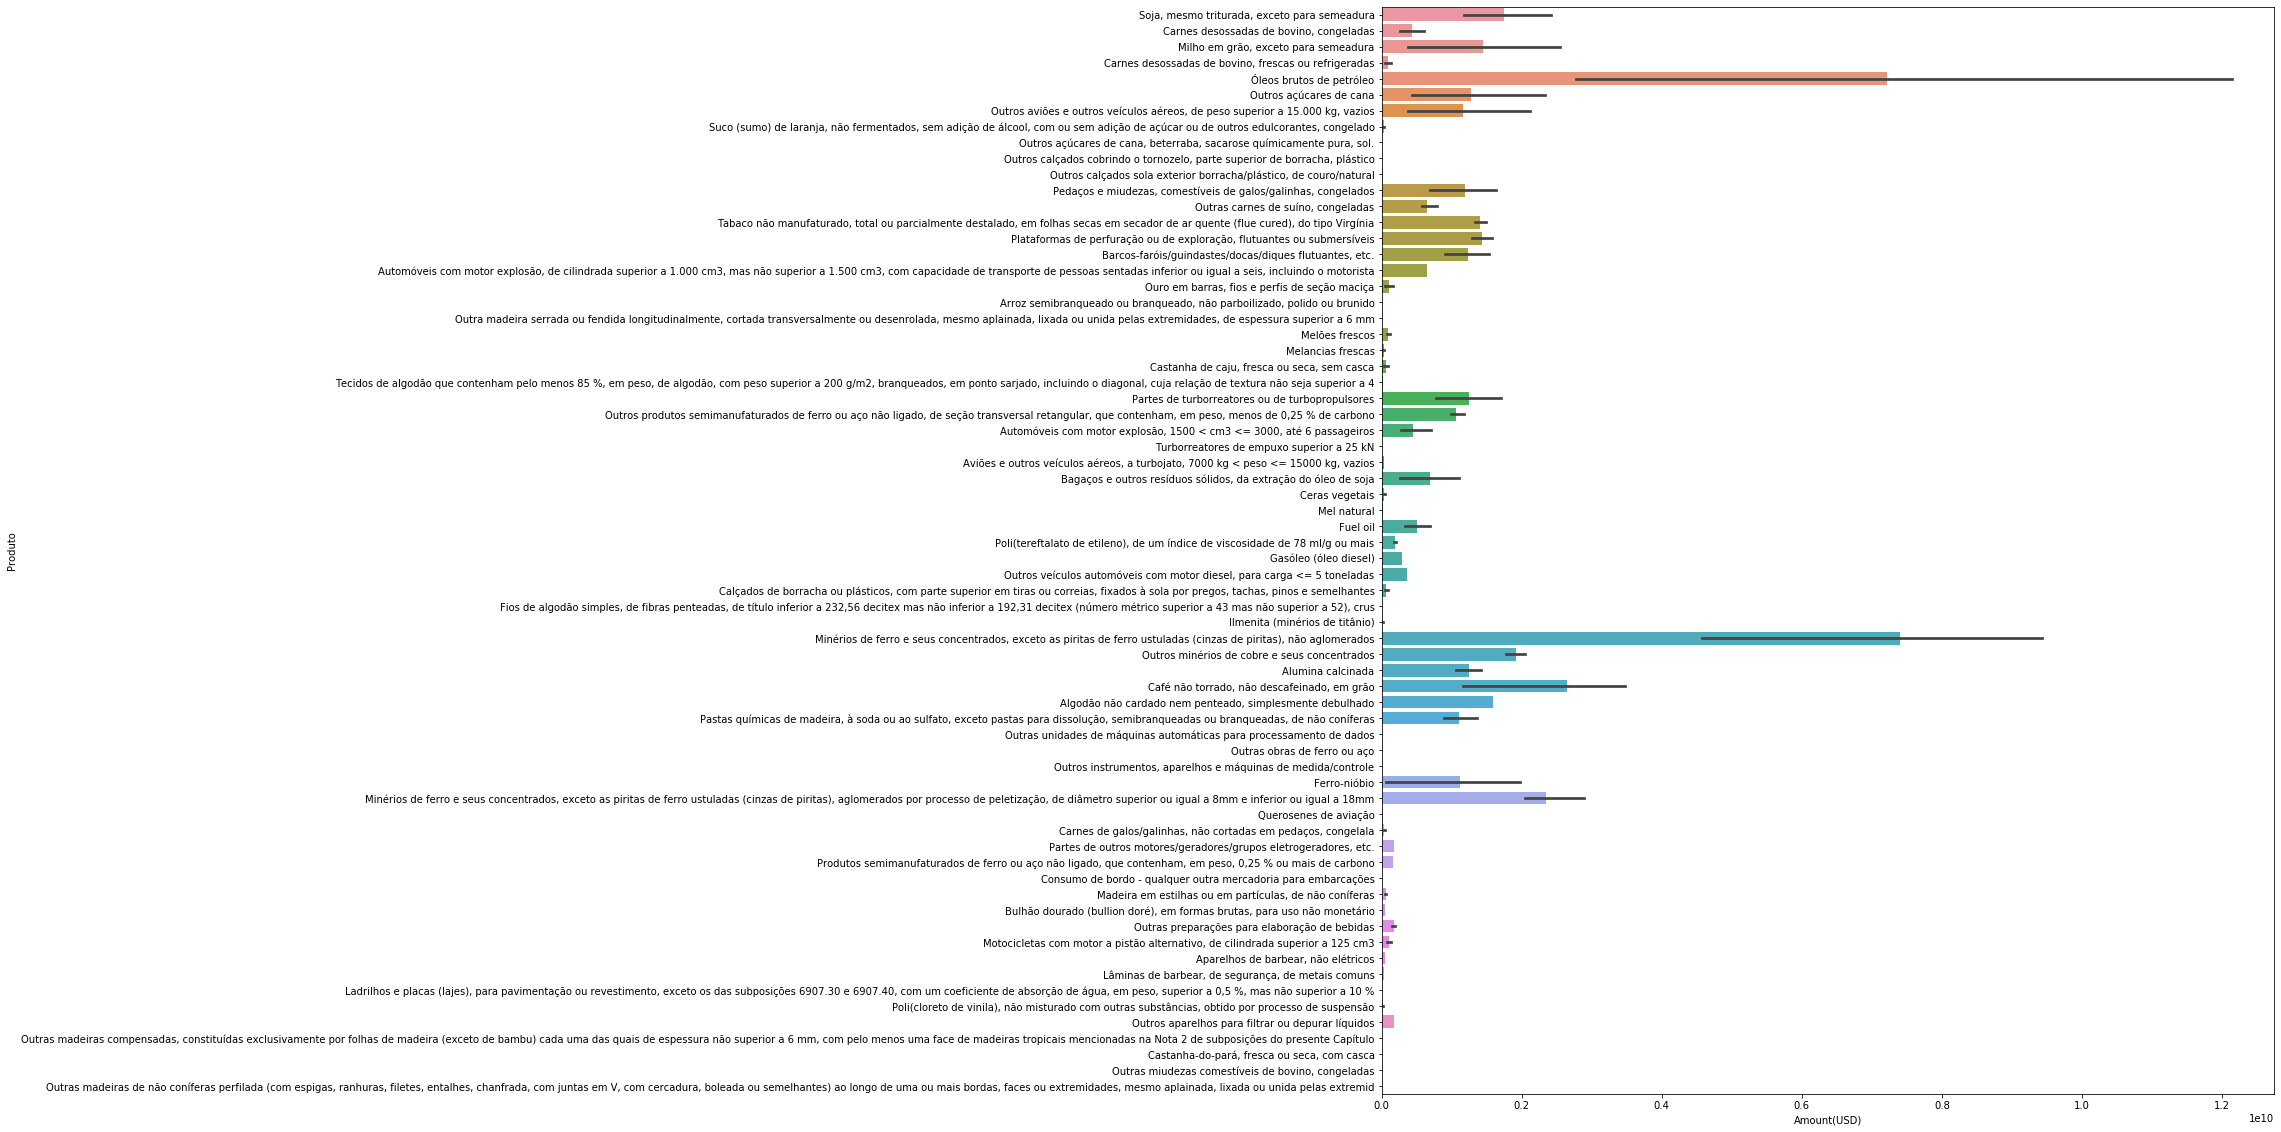

In [53]:
plt.figure(figsize=(16, 20))
ax = sns.barplot(x="Amount(USD)", y="Produto",data=exp_grouped)

We have a rate of around 1:1 of product to state. This leaves us some 

In [45]:
exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Mes','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Mes','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Mes','Ano'],ascending=False)
exp_grouped.head(10)

,Ano,Mes,Estado,Produto,Amount(USD)
237711,2019,12,TO,"Soja, mesmo triturada, exceto para semeadura",24404810
237689,2019,12,TO,"Carnes desossadas de bovino, congeladas",21599502
237695,2019,12,TO,"Milho em grão, exceto para semeadura",4946941
217438,2019,11,TO,"Soja, mesmo triturada, exceto para semeadura",39979339
217404,2019,11,TO,"Carnes desossadas de bovino, congeladas",25670606
217411,2019,11,TO,"Milho em grão, exceto para semeadura",5680944
197570,2019,10,TO,"Soja, mesmo triturada, exceto para semeadura",36715944
197547,2019,10,TO,"Carnes desossadas de bovino, congeladas",18106841
197552,2019,10,TO,"Milho em grão, exceto para semeadura",13944446
176919,2019,9,TO,"Soja, mesmo triturada, exceto para semeadura",76427859


In [46]:
exp_grouped['Produto'].drop_duplicates().count()

112

In [47]:
exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Estado'], as_index=False)['Amount(USD)'].sum()
exp_grouped.head(10)

,Ano,Estado,Amount(USD)
0,2019,AC,32853291
1,2019,AL,319088835
2,2019,AM,731091968
3,2019,AP,261368366
4,2019,BA,8168158116
5,2019,CE,2275188077
6,2019,DF,160701336
7,2019,ES,8800321849
8,2019,GO,7133398211
9,2019,MA,3543622779


In [36]:
total_sum = exp_grouped['Amount(USD)'].sum()
print(total_sum)

225383482468


In [37]:
exp_grouped['percentage'] = exp_grouped.apply(lambda x: (x['Amount(USD)'] / total_sum) * 100, axis=1)
exp_grouped = exp_grouped.sort_values(by='percentage',ascending=False)
exp_grouped.head(10)

,Ano,Estado,Amount(USD),percentage
26,2019,SP,48852560073,21.675306
19,2019,RJ,28634458633,12.704772
10,2019,MG,25138578745,11.153692
23,2019,RS,18545065307,8.228227
14,2019,PA,17841239155,7.915948
12,2019,MT,17206103910,7.634146
18,2019,PR,16454197120,7.300534
24,2019,SC,8951838846,3.971826
7,2019,ES,8800321849,3.904599
4,2019,BA,8168158116,3.624116


Text(0.5, 1.0, 'Percentage of Exports for 2019')

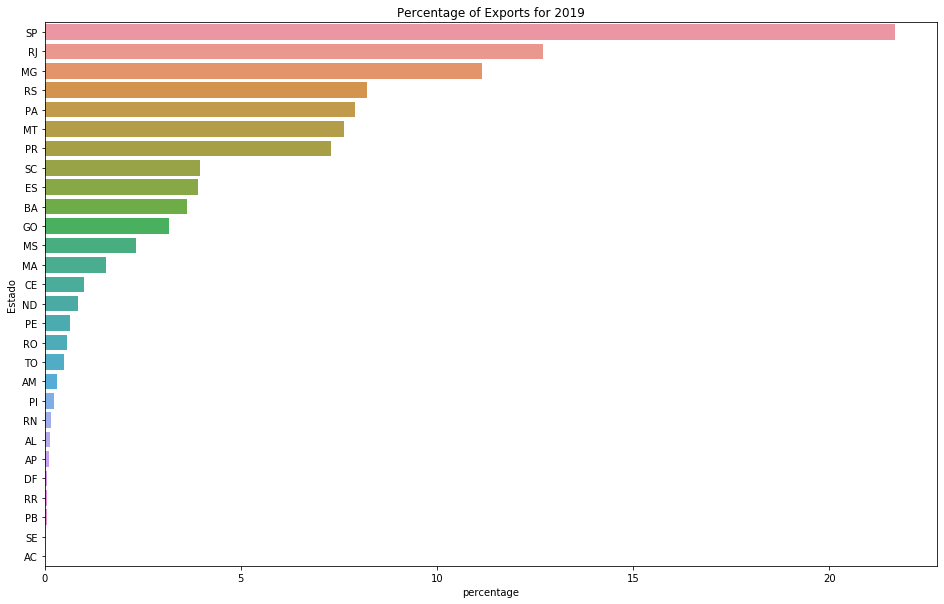

In [39]:
plt.figure(figsize=(16, 10))
ax = sns.barplot(x="percentage", y="Estado",data=exp_grouped)
ax.set_title("Percentage of Exports for 2019")